In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Feb22_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100

QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD_Pt_300to470                         WW
QCD_Pt_3200toInf       

In [3]:
# # counts number of events for a given sample after skimming
# for sample in os.listdir("../Jan20_2017/"):
#     if sample != "SingleMuon_Run2017E":
#         continue
#     out_files = f"{samples_dir}/{sample}/outfiles/"
#     parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")

#     if not parquet_files:
#         print(f"No parquet file for {sample}")
#         continue                

#     data = pd.read_parquet(parquet_files)
#     not_empty = len(data) > 0

#     print(f"Finding {len(data)} events for {sample}")

# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- saves the combined dataframe under `events[ch][sample]`

In [4]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [5]:
samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

channels = ["mu", "ele"]

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

In [6]:
presel = {
    "mu": {
        "preselection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",          
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
    },
    "ele": {
        "preselection": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
    }    
}

    
samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

events_dict = {}
for ch in channels:
    events_dict[ch] = {}

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        is_data = False
        if sample_to_use == data_by_ch[ch]:
            is_data = True         

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # apply selection
        print("---> Applying preselection.")
        for selection in presel[ch]:
            print(f"applying {selection} selection on {len(data)} events")
            data = data.query(presel[ch][selection])  
        print("---> Done with preselection.")

        # get event_weight
        if not is_data:       
            print("---> Accumulating event weights.")                
            event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
            for w in weights[ch]:
                if w not in data.keys():
                    print(f"{w} weight is not stored in parquet")
                    continue
                event_weight *= data[w]
            print("---> Done with accumulating event weights.")                       
        else:
            event_weight = np.ones_like(data["fj_pt"])

        data["event_weight"] = event_weight

        print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
        print(f"tot event weight {data['event_weight'].sum()} \n")

        # fill the big dataframe
        if sample_to_use not in events_dict[ch].keys():
            events_dict[ch][sample_to_use] = data
        else:
            events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying preselection selection on 964 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 949 events
tot event weight 1543.7711110497626 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
applying preselection selection on 9908 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 9814 events
tot event weight 99.1718310827731 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Applying preselection.
applying preselection selection on 1177 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done

---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 39211 events
tot event weight 1279.8312339180088 

Finding WminusHToTauTau samples and should combine them under WminusHToTauTau
No parquet file for WminusHToTauTau
Finding TTTo2L2Nu samples and should combine them under TTbar
---> Applying preselection.
applying preselection selection on 535201 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 520678 events
tot event weight 16146.139085911556 

Finding ttHToTauTau samples and should combine them under ttHToTauTau
No parquet file for ttHToTauTau
Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Applying preselection.
applying preselection select

---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 91690 events
tot event weight 45814.75362024214 

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 10424 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 8670 events
tot event weight 10147.106418026702 

Finding HZJ_HToWW_M-125 samples and should combine them under VH
---> Applying preselection.
applying preselection selection on 16286 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VH dataframe with the remaining 15723 events
tot event weight 17.55506092019437 

F

---> Applying preselection.
applying preselection selection on 20379 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 19803 events
tot event weight 2893.416329370738 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 728 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 719 events
tot event weight 0.4868421696225197 

Finding WW samples and should combine them under Diboson
---> Applying preselection.
applying preselection selection on 2527 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the Diboson dataframe w

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 1281 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1218 events
tot event weight 1338.759662206114 

Finding HZJ_HToWW_M-125 samples and should combine them under VH
---> Applying preselection.
applying preselection selection on 12573 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VH dataframe with the remaining 12188 events
tot event weight 13.049154829134752 

Finding WZ samples and should combine them under Diboson
---> Applying preselection.
applying preselection selection on 1186 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_no

In [7]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [8]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttHToNonbb_M125'])

# Plot histograms

In [9]:
nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

## 1d-hists

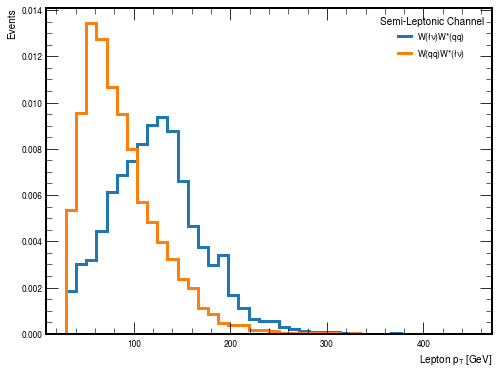

In [10]:
# make simple 1d-histogram of `lep_pt`
var = "lep_pt"

# fill histograms
h = hist2.Hist(
    utils.axis_dict[var],
    hist2.axis.Boolean(name="from_W")        
)

for ch in ["mu", "ele"]:
    h.fill(
        var=events_dict[ch]["HWW"][var],
        from_W=events_dict[ch]["HWW"]["fj_H_VV_isVlepton"]==True,
        weight=events_dict[ch]["HWW"]["event_weight"]
    )

plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
    density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
    density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

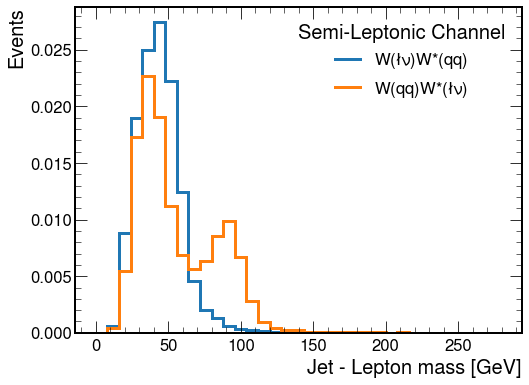

In [11]:
# make simple 1d-histogram of `jet-lep mass`
var = "lep_fj_m"

# fill histograms
h = hist2.Hist(
    utils.axis_dict[var],
    hist2.axis.Boolean(name="from_W")        
)

for ch in ["mu", "ele"]:
    h.fill(
        var=events_dict[ch]["HWW"][var],
        from_W=events_dict[ch]["HWW"]["fj_H_VV_isVlepton"]==True,
        weight=events_dict[ch]["HWW"]["event_weight"]
    )

plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
    density=True
    
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
    density=True
)
     
xch = nice_channel[ch]
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

In [13]:
events_dict[ch]["HWW"]["lep_met_mt"]

0       22.697506
1       78.096611
2       33.296963
3       67.520004
4       33.297745
          ...    
9644     4.751327
9645    44.959255
9646    18.760798
9647     8.396637
9648    66.669289
Name: lep_met_mt, Length: 9317, dtype: float32

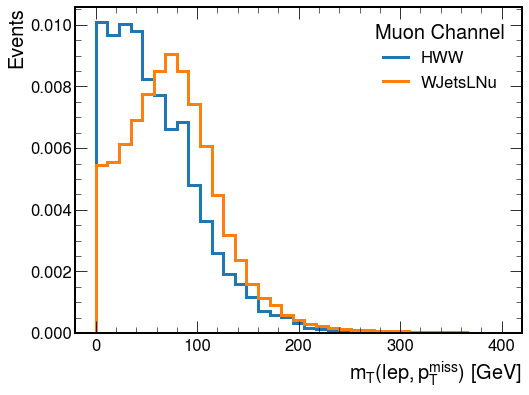

In [28]:
plt.rcParams.update({"font.size": 20})
# make simple 1d-histogram of `jet-lep mass`
var = "lep_met_mt"

channels = ["mu", "ele"]
channels = ["mu"]

samples = ["HWW", "WJetsLNu"]

fig, ax = plt.subplots(figsize=(8, 6))
for sample in samples:
        # fill histograms
    h = hist2.Hist(
        utils.axis_dict[var],
    )
    for ch in channels:
        h.fill(
            var=events_dict[ch][sample][var],
            weight=events_dict[ch][sample]["event_weight"]
        )

    hep.histplot(
        h,
        ax=ax,
        label=f"{sample}",
        linewidth=3,
        density=True
    )
     
xch = nice_channel[ch]
if len(channels)==2:
    ax.legend(title=f"Semi-Leptonic Channel")
else:
    ax.legend(title=f"{nice_channel[ch]} Channel")
ax.set_ylabel("Events");

## Stacked hists

In [18]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "mu": "Muon",    
    "ele": "Electron",
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

In [19]:
def plot_hists(ch, hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False):
    # data label
    data_label = data_by_ch[ch]

    # luminosity
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]
        luminosity = luminosity / 1000.0

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signals]
        bkg_labels = [
            label
            for label in samples
            if (label and label != data_label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        data = None
        if data_label in h.axes[0]:
            data = h[{"samples": data_label}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
#                 fig, ax = plt.subplots(1, 1)
                fig, ax = plt.subplots(figsize=(8,8))                
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "lep_fj_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
#             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
#             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"{label_by_ch[ch]} Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [20]:
json_vars = {
  "mu": {
#     "lep_fj_m": 1,
    "fj_pt": 1,
#     "lep_pt": 1,
#     "fj_msoftdrop": 1,
#     "fj_bjets_ophem": 1,
#     "fj_bjets": 1,
#     "lep_isolation_lowpt": 1,
#     "lep_isolation_highpt": 1,
#     "lep_misolation_lowpt": 1,
#     "lep_misolation_highpt": 1,
#     "lep_fj_dr": 1,
    "lep_met_mt": 1,
#     "ht": 1,
#     "met": 1,
#     "met_fj_dphi": 1,
#     "nfj": 1,
#     "nj": 1,
#     "deta": 1,
#     "mjj": 1,
#       "rec_higgs_m": 1,
  },
  "ele": {
    "lep_fj_m": 1,
    "fj_pt": 1,
    "lep_pt": 1,
#     "rec_higgs_m": 1,
  }
}

In [23]:
ch = "ele"

### get vars_to_plot
vars_to_plot = []
for key, value in json_vars[ch].items():
    if value == 1:
        vars_to_plot.append(key)    
# 
### get samples_to_plot
samples_to_plot = list(events_dict[ch].keys())
# samples_to_plot = ["HWW", "QCD", "TTbar"]

# fill histograms
hists = {}
for var in vars_to_plot:
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 125, 350, name="var", label=r"rec_higgs_m [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        hists[var].fill(
            samples=sample,
            var=events_dict[ch][sample][var],
            weight=events_dict[ch][sample]["event_weight"]
        )


hists["fj_pt"][{"samples": "HWW"}]        

Hist(Regular(30, 200, 1000, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 73.25020956233345 (73.2575907207458 with flow)

Will plot lep_fj_m histogram
Will plot fj_pt histogram
Will plot lep_pt histogram


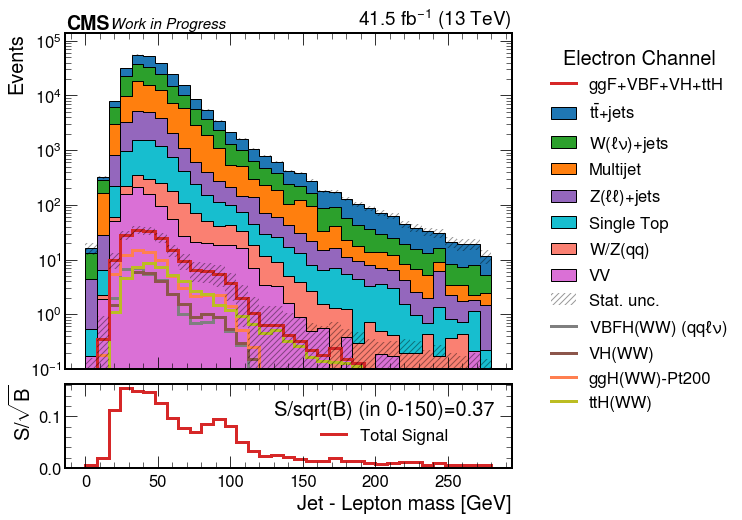

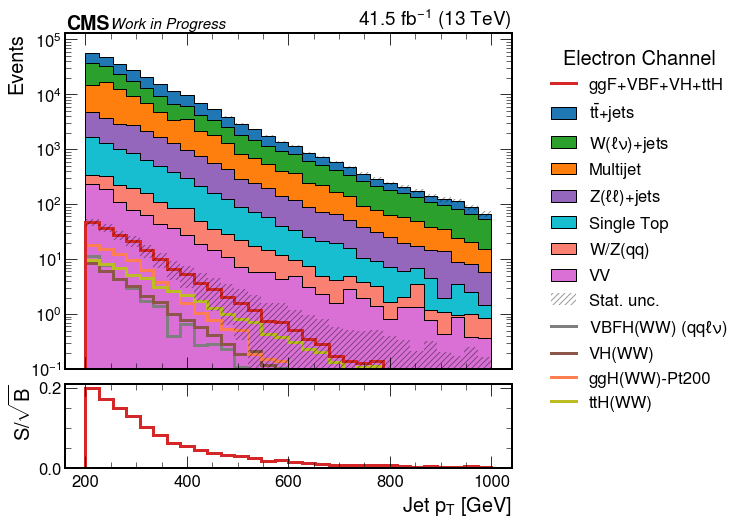

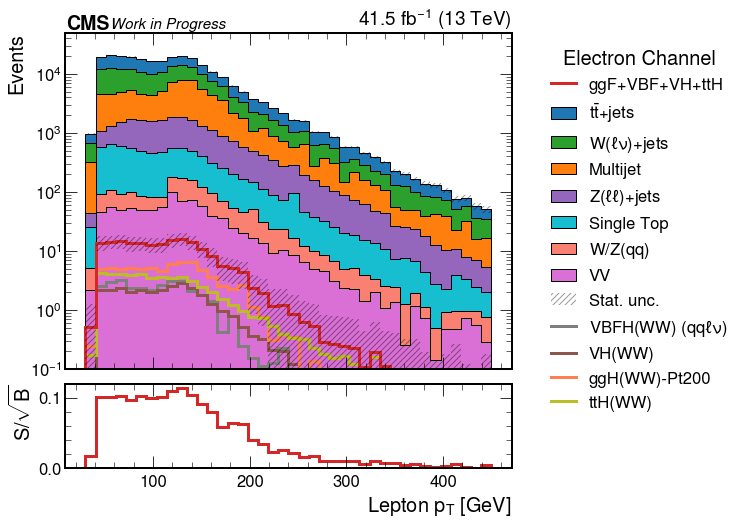

In [24]:
plt.rcParams.update({"font.size": 20})
plt.rcParams.update({"font.size": 20})
plot_hists(ch, hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False)

# Regressed mass

Will plot fj_ParT_mass histogram


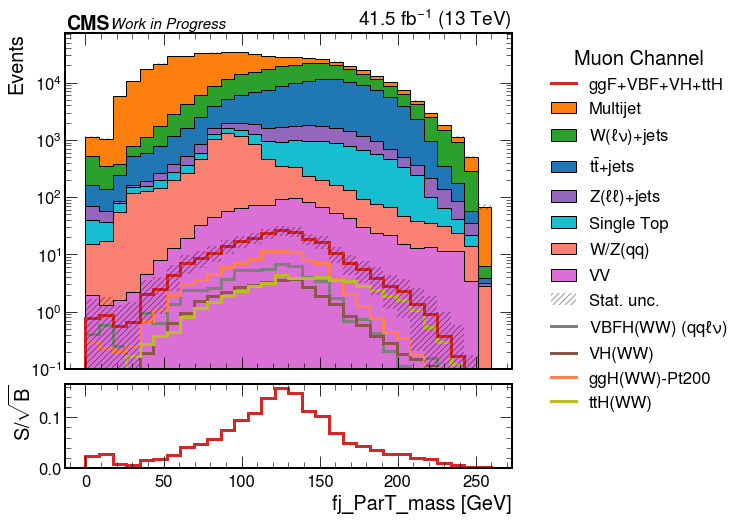

In [73]:
ch = "mu"

### get samples_to_plot
samples_to_plot = list(events_dict[ch])

# fill histograms
hists = {}
for var in ["fj_pt", "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        hists[var].fill(
            samples=sample,
            var=events_dict[ch][sample][var],
            weight=events_dict[ch][sample]["event_weight"]
        )

plot_hists(ch, hists, ["fj_ParT_mass"], add_data = True, logy = True, add_soverb = True, only_sig = False)   

## Adding softdrop cut

Will plot fj_ParT_mass histogram
Adding cut: fj_msoftdrop < 260GeV


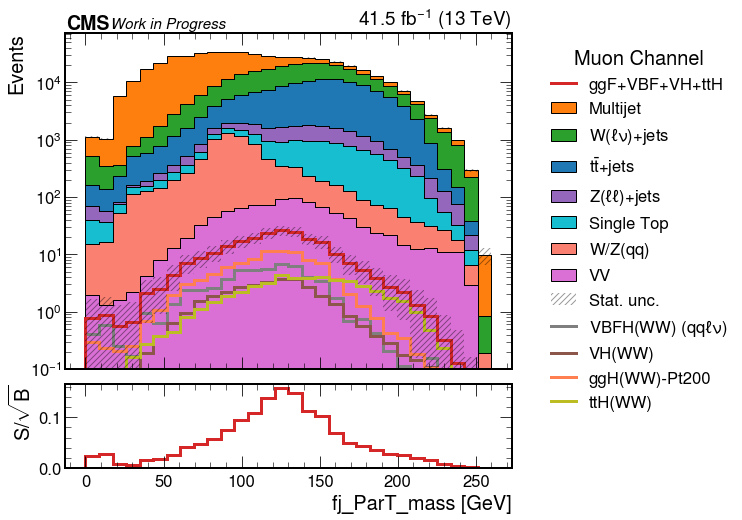

In [137]:
ch = "mu"

### get samples_to_plot
samples_to_plot = list(events_dict[ch])

# fill histograms
hists = {}
for var in ["fj_pt", "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        msoftdrop_cut = (events_dict[ch][sample]["fj_msoftdrop"] < 260)
        hists[var].fill(
            samples=sample,
            var=events_dict[ch][sample][var][msoftdrop_cut],
            weight=events_dict[ch][sample]["event_weight"][msoftdrop_cut]
        )

plot_hists(ch, hists, ["fj_ParT_mass"], add_data = True, logy = True, add_soverb = True, only_sig = False)
print("Adding cut: fj_msoftdrop < 260GeV")

Will plot fj_ParT_mass histogram
Adding cut: fj_msoftdrop < 260GeV


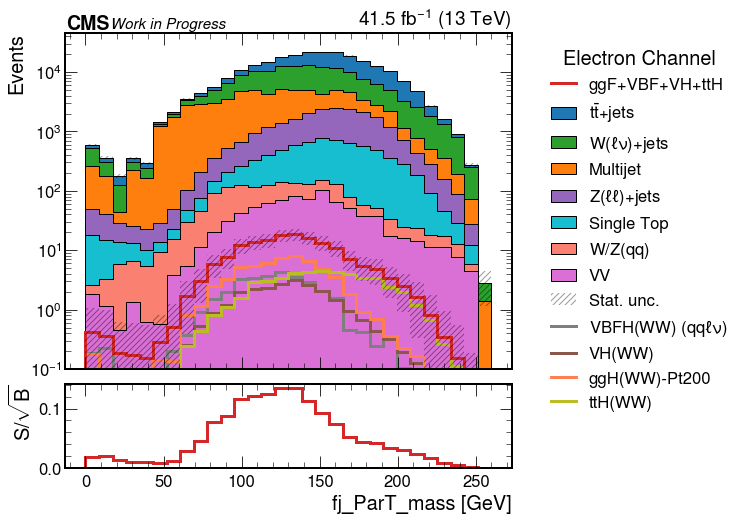

# Integrating tagger score

In [45]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]

qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]

tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]

# define signals and bkgs score
sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}

bkgs = {
    "ele": tope+topm+tophad+qcd,
    "mu": tope+topm+tophad+qcd,
}

In [46]:
presel = {
    "mu": {
        "preselection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",          
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
    },
    "ele": {
        "preselection": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
    }    
}

new_sig = [s.replace("PN","ParT") for s in sigs[ch]]
new_bkg = [b.replace("PN","ParT") for b in bkgs[ch]]
        
events_dict, tagger_scores = {}, {}
for ch in channels:
    events_dict[ch], tagger_scores[ch] = {}, []

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        is_data = False
        if sample_to_use == data_by_ch[ch]:
            is_data = True         

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # apply selection
        print("---> Applying preselection.")
        for selection in presel[ch]:
            print(f"applying {selection} selection on {len(data)} events")
            data = data.query(presel[ch][selection])  
        print("---> Done with preselection.")

        # get event_weight
        if not is_data:       
            print("---> Accumulating event weights.")                
            event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
            for w in weights[ch]:
                if w not in data.keys():
                    print(f"{w} weight is not stored in parquet")
                    continue
                event_weight *= data[w]
            print("---> Done with accumulating event weights.")                       
        else:
            event_weight = np.ones_like(data["fj_pt"])

        data["event_weight"] = event_weight

        print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
        print(f"tot event weight {data['event_weight'].sum()} \n")

        # get tagger score
        data["tagger_output"] = disc_score(data,new_sig,new_bkg)   
        
        # fill the big dataframe
        if sample_to_use not in events_dict[ch].keys():
            events_dict[ch][sample_to_use] = data
        else:
            events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])    

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying preselection selection on 964 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 949 events
tot event weight 1543.7711110497626 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
applying preselection selection on 9908 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 9814 events
tot event weight 99.1718310827731 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Applying preselection.
applying preselection selection on 1177 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done

---> Applying preselection.
applying preselection selection on 535201 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 520678 events
tot event weight 16146.139085911556 

Finding ttHToTauTau samples and should combine them under ttHToTauTau
No parquet file for ttHToTauTau
Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 3443 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 2881 events
tot event weight 0.19702627036240436 

Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
---> Applying preselection.
applying preselection selection on 21351 events
---> Done w

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 10424 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 8670 events
tot event weight 10147.106418026702 

Finding HZJ_HToWW_M-125 samples and should combine them under VH
---> Applying preselection.
applying preselection selection on 16286 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VH dataframe with the remaining 15723 events
tot event weight 17.55506092019437 

Finding WZ samples and should combine them under Diboson
---> Applying preselection.
applying preselection selection on 1169 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_n

Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
---> Applying preselection.
applying preselection selection on 25645 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 25282 events
tot event weight 80.07707629029917 

Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
---> Applying preselection.
applying preselection selection on 20379 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 19803 events
tot event weight 2893.416329370738 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 728 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nomin

Finding ttHToNonbb_M125 samples and should combine them under ttHToNonbb_M125
---> Applying preselection.
applying preselection selection on 15493 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the ttHToNonbb_M125 dataframe with the remaining 15018 events
tot event weight 50.502961524920636 

Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
---> Applying preselection.
applying preselection selection on 867 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 772 events
tot event weight 60.074152876288004 

Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> Applying preselection.
applying preselection selection on 1844 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weig

Will plot fj_ParT_mass histogram
Adding cut: fj_msoftdrop < 260GeV
Adding tagger cut > 0.99


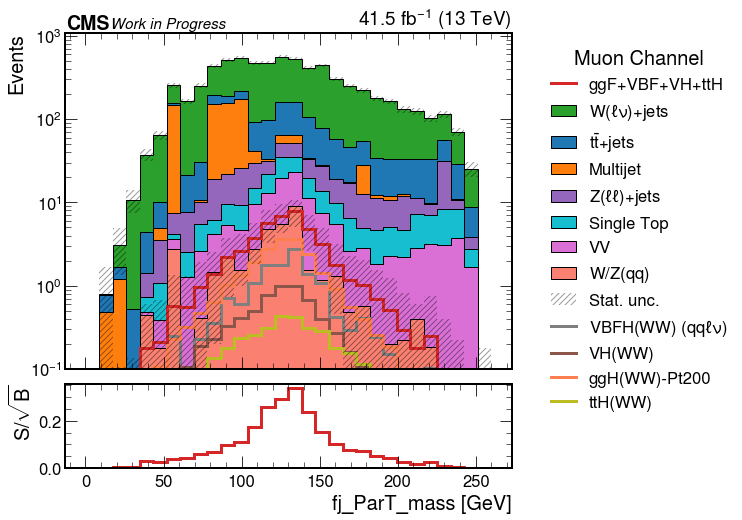

In [132]:
ch = "mu"
cut = 0.99

### get samples_to_plot
samples_to_plot = list(events_dict[ch])

# fill histograms
hists = {}
for var in ["fj_pt", "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        msoftdrop_cut = (events_dict[ch][sample]["fj_msoftdrop"] < 260)
        tagger_cut = (events_dict[ch][sample]["tagger_output"]>cut)
        
        hists[var].fill(
            samples=sample,
            var=events_dict[ch][sample][var][msoftdrop_cut & tagger_cut],
            weight=events_dict[ch][sample]["event_weight"][msoftdrop_cut & tagger_cut]
        )

plot_hists(ch, hists, ["fj_ParT_mass"], add_data = True, logy = True, add_soverb = True, only_sig = False)
print("Adding cut: fj_msoftdrop < 260GeV")
print(f"Adding tagger cut > {cut}")

## Combining ele and muons

In [133]:
cut = 0.99

### get samples_to_plot
samples_to_plot = list(events_dict[ch])

# fill histograms
hists = {}
for var in ["fj_pt", "lep_fj_m"]:#, "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        
        for ch in ["mu", "ele"]:
            msoftdrop_cut = (events_dict[ch][sample]["fj_msoftdrop"] < 260)
            tagger_cut = (events_dict[ch][sample]["tagger_output"]>cut)
            tagger_cut = True

            hists[var].fill(
                samples=sample,
                var=events_dict[ch][sample][var][msoftdrop_cut & tagger_cut],                
                weight=events_dict[ch][sample]["event_weight"][msoftdrop_cut & tagger_cut]
                
            )

        
print("Adding cut: fj_msoftdrop < 260GeV")
print(f"Adding tagger cut > {cut}")

Adding cut: fj_msoftdrop < 260GeV
Adding tagger cut > 0.99


Will plot lep_fj_m histogram


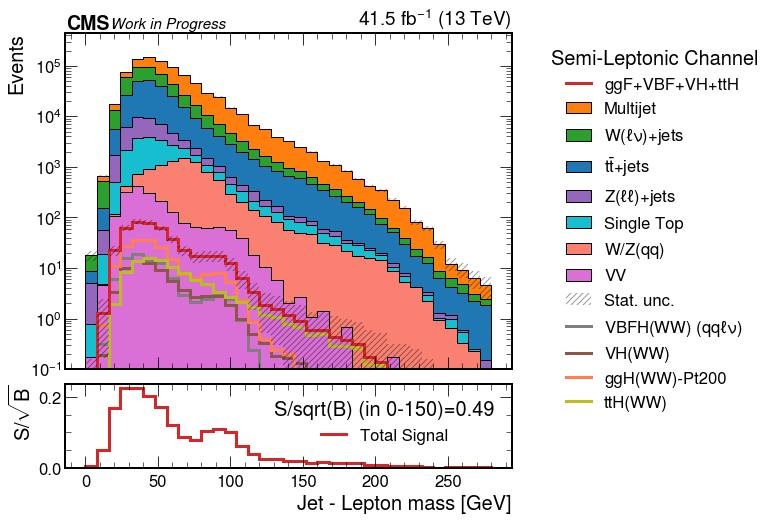

In [134]:
vars_to_plot = ["lep_fj_m"]
add_data = False
logy = True
add_soverb = True
only_sig = False



# luminosity
luminosity = 0
for ch in channels:
    with open("../fileset/luminosity.json") as f:
        lum = json.load(f)[ch]["2017"]
        luminosity += lum / 1000.0
luminosity = luminosity/2
        
for var in vars_to_plot:
    if var not in hists.keys():
        print(f"{var} not stored in hists")
        continue

    print(f"Will plot {var} histogram")

    # get histograms
    h = hists[var]

    if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
        print("Empty histogram ", var)
        continue

    # get samples existing in histogram
    samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
    signal_labels = [label for label in samples if label in signals]
    bkg_labels = [
        label
        for label in samples
        if (label and label not in signal_labels)
    ]

    # get total yield of backgrounds per label
    # (sort by yield in fixed fj_pt histogram after pre-sel)        
    order_dic = {}
    for bkg_label in bkg_labels:
        if "fj_pt" in hists.keys():
            order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
        else:
            order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()

    # data
    data = None

    # signal
    signal = [h[{"samples": label}] for label in signal_labels]
    # scale signal for non-log plots
    if logy:
        mult_factor = 1
    else:
        mult_factor = 100
    signal_mult = [s * mult_factor for s in signal]

    # background
    bkg = [h[{"samples": label}] for label in bkg_labels]

    if add_data and data and len(bkg) > 0:
        if add_soverb and len(signal) > 0:
            fig, (ax, rax, sax) = plt.subplots(
                nrows=3,
                ncols=1,
                figsize=(8, 8),
                gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                sharex=True,
            )
        else:
            fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(8, 8),
                gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                sharex=True,
            )
            sax = None
    else:
        if add_soverb and len(signal) > 0:
            fig, (ax, sax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(8, 8),
                gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                sharex=True,
            )
            rax = None
        else:
#                 fig, ax = plt.subplots(1, 1)
            fig, ax = plt.subplots(figsize=(8,8))                
            rax = None
            sax = None

    errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "k",
        "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    }

    # sum all of the background
    if len(bkg) > 0:
        tot = bkg[0].copy()
        for i, b in enumerate(bkg):
            if i > 0:
                tot = tot + b

        tot_val = tot.values()
        tot_val_zero_mask = tot_val == 0
        tot_val[tot_val_zero_mask] = 1

        tot_err = np.sqrt(tot_val)
        tot_err[tot_val_zero_mask] = 0

        # print(f'Background yield: ',tot_val,np.sum(tot_val))

    if add_data and data:
        data_err_opts = {
            "linestyle": "none",
            "marker": ".",
            "markersize": 10.0,
            "elinewidth": 1,
        }
        hep.histplot(
            data,
            ax=ax,
            histtype="errorbar",
            color="k",
            capsize=4,
            yerr=True,
            label=data_label,
            **data_err_opts,
        )

        if len(bkg) > 0:
            from hist.intervals import ratio_uncertainty

            data_val = data.values()
            data_val[tot_val_zero_mask] = 1

            yerr = ratio_uncertainty(data_val, tot_val, "poisson")

            hep.histplot(
                data_val / tot_val,
                tot.axes[0].edges,
                # yerr=np.sqrt(data_val) / tot_val,
                yerr=yerr,
                ax=rax,
                histtype="errorbar",
                color="k",
                capsize=4,
            )

            rax.axhline(1, ls="--", color="k")
            rax.set_ylim(0.2, 1.8)
            # rax.set_ylim(0.7, 1.3)

    # plot the background
    if len(bkg) > 0 and not only_sig:
        hep.histplot(
            bkg,
            ax=ax,
            stack=True,
            sort="yield",
            edgecolor="black",
            linewidth=1,
            histtype="fill",
            label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
            color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
        )
        ax.stairs(
            values=tot.values() + tot_err,
            baseline=tot.values() - tot_err,
            edges=tot.axes[0].edges,
            **errps,
            label="Stat. unc.",
        )

    # plot the signal (times 10)
    if len(signal) > 0:
        tot_signal = None
        for i, sig in enumerate(signal_mult):
            lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
            if mult_factor == 1:
                lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
            hep.histplot(
                sig,
                ax=ax,
                label=lab_sig_mult,
                linewidth=3,
                color=color_by_sample[signal_labels[i]],
            )

            if tot_signal == None:
                tot_signal = signal[i].copy()
            else:
                tot_signal = tot_signal + signal[i]

        # plot the total signal (w/o scaling)
        hep.histplot(
            tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
        )
        # add MC stat errors
        ax.stairs(
            values=tot_signal.values() + np.sqrt(tot_signal.values()),
            baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
            edges=sig.axes[0].edges,
            **errps,
        )

        if sax is not None:
            totsignal_val = tot_signal.values()
            # replace values where bkg is 0
            totsignal_val[tot_val == 0] = 0
            soverb_val = totsignal_val / np.sqrt(tot_val)
            hep.histplot(
                soverb_val,
                tot_signal.axes[0].edges,
                label="Total Signal",
                ax=sax,
                linewidth=3,
                color="tab:red",
            )

            # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
            if var == "lep_fj_m":
                bin_array = tot_signal.axes[0].edges[
                    :-1
                ]  # remove last element since bins have one extra element
                range_max = 150
                range_min = 0

                condition = (bin_array >= range_min) & (bin_array <= range_max)

                s = totsignal_val[
                    condition
                ].sum()  # sum/integrate signal counts in the range
                b = np.sqrt(
                    tot_val[condition].sum()
                )  # sum/integrate bkg counts in the range and take sqrt

                soverb_integrated = round((s / b).item(), 2)
                sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

    ax.set_ylabel("Events")
    if sax is not None:
        ax.set_xlabel("")
        if rax is not None:
            rax.set_xlabel("")
            rax.set_ylabel("Data/MC", fontsize=20)
        sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
#             sax.set_xlabel(f"{utils.axis_dict[var].label}")
        sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis

    elif rax is not None:
        ax.set_xlabel("")
#             rax.set_xlabel(f"{utils.axis_dict[var].label}")
        rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis

        rax.set_ylabel("Data/MC", fontsize=20)

    # get handles and labels of legend
    handles, labels = ax.get_legend_handles_labels()

    # append legend labels in order to a list
    summ = []
    for label in labels[: len(bkg_labels)]:
        summ.append(order_dic[label])
    # get indices of labels arranged by yield
    order = []
    for i in range(len(summ)):
        order.append(np.argmax(np.array(summ)))
        summ[np.argmax(np.array(summ))] = -100

    # plot data first, then bkg, then signal
    hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
    lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

    ax.legend(
        [hand[idx] for idx in range(len(hand))],
        [lab[idx] for idx in range(len(lab))],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        title=f"Semi-Leptonic Channel",
    )

    if logy:
        ax.set_yscale("log")
        ax.set_ylim(1e-1)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

## Back

In [80]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

match_labels = {
    "HWW": "fj_H_VV_isMatched",
    "TTbar": "fj_Top_isMatched",
    "SingleTop": "fj_Top_isMatched",    
    "WJetsLNu": "fj_V_isMatched",
    "DYJets": "fj_V_isMatched",
}

Found 2642 NaN scores out of 14439. Will remove them.
Found 5037 NaN scores out of 78705. Will remove them.
Found 37082 NaN scores out of 1348091. Will remove them.


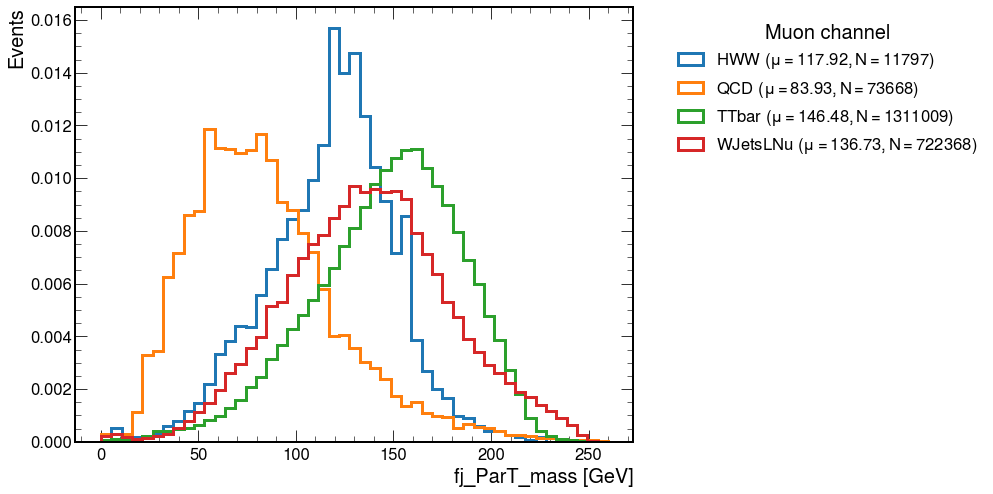

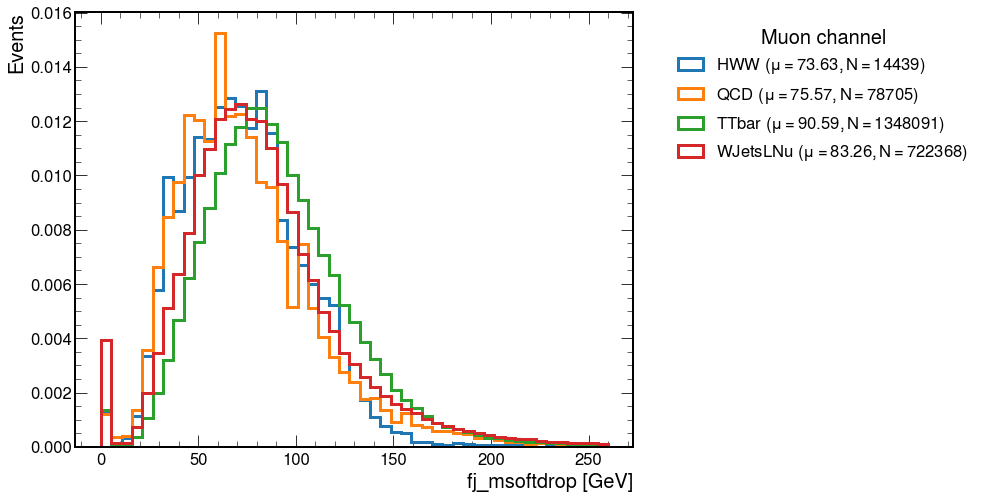

In [192]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,260)

for sample in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
    if sample in match_labels:
        match_bool = (events_dict[ch][sample][match_labels[sample]].values == True)
        X = (events_dict[ch][sample]["fj_ParT_mass"][match_bool].values)
        weights = (events_dict[ch][sample]["event_weight"][match_bool].values)
    else:
        X = events_dict[ch][sample]["fj_ParT_mass"].values
        weights = events_dict[ch][sample]["event_weight"].values

    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
        weights = weights[~is_nan]

    mean = np.sum((X*weights))/weights.sum()
    ax.hist(
        X,
        bins_,
        label="{} $(\mu={:.2f}, N={})$".format(sample, mean, len(X)),
        weights=weights,
        linewidth=3,
        density=True,
        histtype="step"
        )
    
xch = nice_channel[ch]
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("fj_ParT_mass [GeV]");
# ax.set_xticks([0,0.5,1,1.5,2]);


### softdrop
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,260)

for sample in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
    if sample in match_labels:
        match_bool = (events_dict[ch][sample][match_labels[sample]].values == True)
        X = (events_dict[ch][sample]["fj_msoftdrop"][match_bool].values)
        weights = events_dict[ch][sample]["event_weight"][match_bool].values
    else:
        X = events_dict[ch][sample]["fj_msoftdrop"].values
        weights = events_dict[ch][sample]["event_weight"].values

    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
    
    mean = np.sum((X*weights))/weights.sum()    
    ax.hist(
        X,
        bins_,
        label="{} $(\mu={:.2f}, N={})$".format(sample, mean, len(X)),
        weights=weights,
        linewidth=3,
        density=True,
        histtype="step"
        )
xch = nice_channel[ch]
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("fj_msoftdrop [GeV]");
# ax.set_xticks([0,0.5,1,1.5,2]);

After tagger cut score>0.9


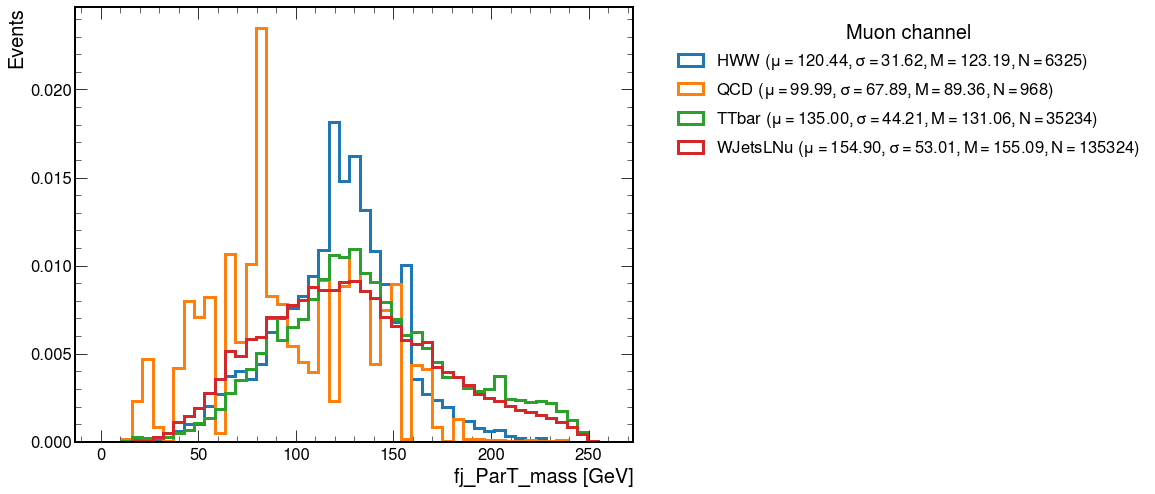

In [108]:
# after tagger cut
ch = "mu"
cut = 0.9

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,260)

PNs = ["ParT"]
for sample in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
    if sample in match_labels:
        match_bool = (events_dict[ch][sample][match_labels[sample]].values == True)
        X = (events_dict[ch][sample]["fj_ParT_mass"][match_bool].values)
        weights = (events_dict[ch][sample]["event_weight"][match_bool].values)
        tagger_output = (events_dict[ch][sample]["tagger_output"][match_bool].values)
    else:
        X = events_dict[ch][sample]["fj_ParT_mass"].values
        weights = events_dict[ch][sample]["event_weight"].values
        tagger_output = (events_dict[ch][sample]["tagger_output"].values)
    
    X = X[tagger_output>cut]
    weights = weights[tagger_output>cut]
    
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
        weights = weights[~is_nan]

    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="{} $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(sample, np.mean(X), np.std(X), p[0], n_matched),
        weights=weights,
        linewidth=3,
        density=True,
        histtype="step"
        )
xch = nice_channel[ch]
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("fj_ParT_mass [GeV]");
# ax.set_xticks([0,0.5,1,1.5,2]);
print(f"After tagger cut score>{cut}")

After tagger cut score>0.9


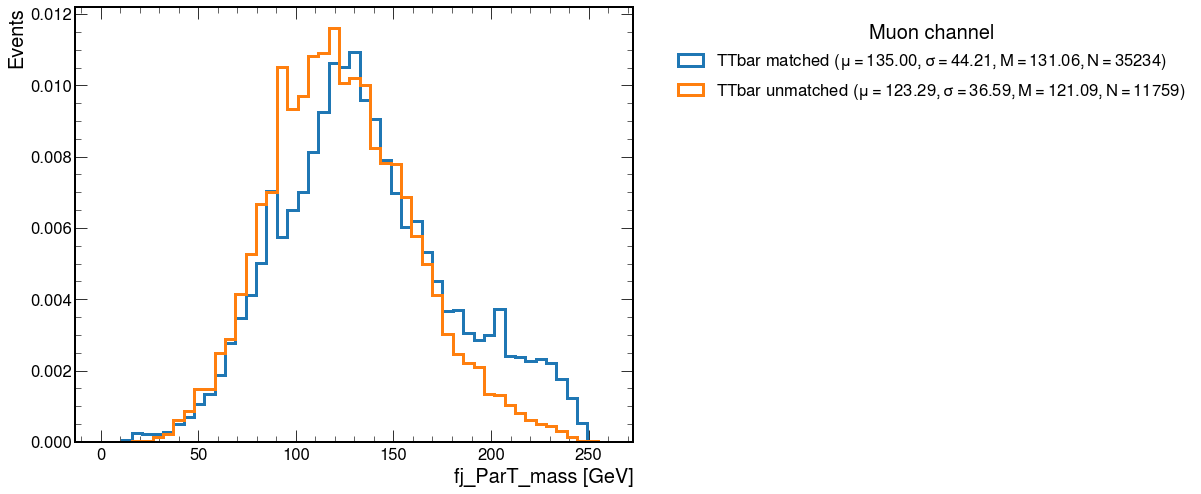

In [112]:
# after tagger cut
ch = "mu"
cut = 0.9

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,260)

PNs = ["ParT"]
for sample in ["TTbar"]:
    
    ### matched Top
    match_bool = (events_dict[ch][sample][match_labels[sample]].values == True)
    X = (events_dict[ch][sample]["fj_ParT_mass"][match_bool].values)
    weights = (events_dict[ch][sample]["event_weight"][match_bool].values)
    tagger_output = (events_dict[ch][sample]["tagger_output"][match_bool].values)

    X = X[tagger_output>cut]
    weights = weights[tagger_output>cut]
    
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
        weights = weights[~is_nan]

    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="{} matched $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(sample, np.mean(X), np.std(X), p[0], n_matched),
        weights=weights,
        linewidth=3,
        density=True,
        histtype="step"
        )
    
    ### unmatched Top
    match_bool = (events_dict[ch][sample][match_labels[sample]].values == False)
    X = (events_dict[ch][sample]["fj_ParT_mass"][match_bool].values)
    weights = (events_dict[ch][sample]["event_weight"][match_bool].values)
    tagger_output = (events_dict[ch][sample]["tagger_output"][match_bool].values)

    X = X[tagger_output>cut]
    weights = weights[tagger_output>cut]
    
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
        weights = weights[~is_nan]

    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="{} unmatched $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(sample, np.mean(X), np.std(X), p[0], n_matched),
        weights=weights,
        linewidth=3,
        density=True,
        histtype="step"
        )    
    
    
xch = nice_channel[ch]
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("fj_ParT_mass [GeV]");
# ax.set_xticks([0,0.5,1,1.5,2]);
print(f"After tagger cut score>{cut}")